In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy import stats
from scipy import optimize

In [2]:
import matplotlib as mpl
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['legend.fontsize'] = 'xx-large'
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['lines.linewidth'] = 2.5
mpl.rcParams['figure.figsize'] = (10, 7)

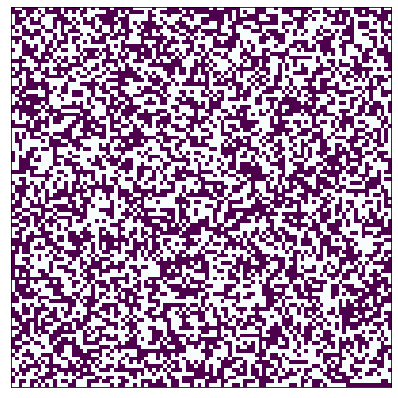

In [3]:
import ising
spins = ising.spinLattice(100)
spins.plot()

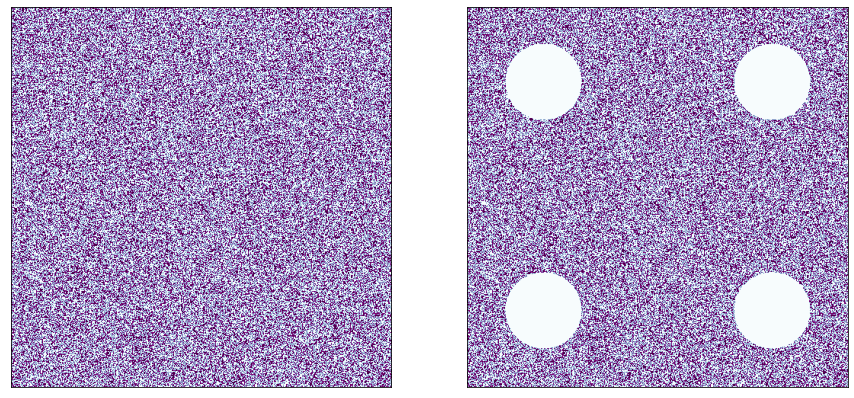

In [4]:
spins = ising.spinLattice(500)
spins.randomize()

def perturbate(s, x0, y0, R):
    N = s.spins.shape[0]
    x, y = np.meshgrid(np.arange(N), np.arange(N))
    x, y = x.flatten(), y.flatten()
    d = np.sqrt((x-x0)**2  + (y-y0)**2)
    xPert, yPert = x[d<R], y[d<R]
    s.spins[xPert, yPert] = -1
    return s

plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
spins.plot()

plt.subplot(1, 2, 2)
a = perturbate(spins, 100, 100, 50)
a = perturbate(spins, 400, 400, 50)
a = perturbate(spins, 100, 400, 50)
a = perturbate(spins, 400, 100, 50)
spins.plot()

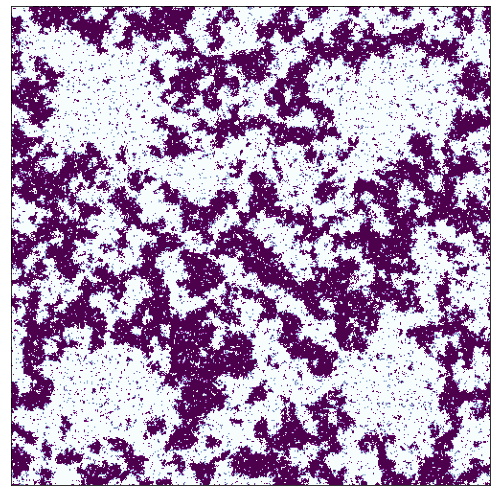

In [5]:
from IPython.display import Image
anim = spins.animate(T=2.1 , nEvolutions=200, saveName='AnimBelowTc')
Image(url='AnimBelowTc.gif')

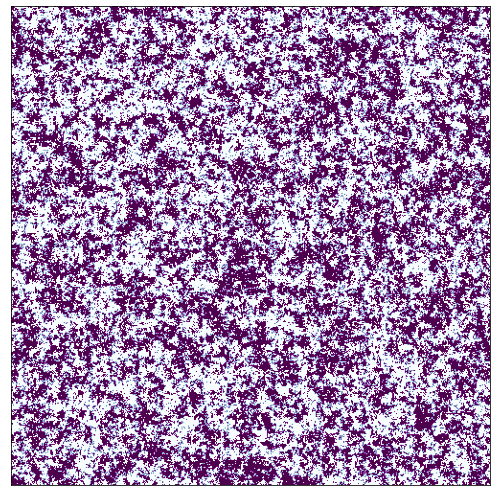

In [6]:
anim = spins.animate(T=2.5, nEvolutions=200, saveName='AnimAboveTc')
Image(url='AnimAboveTc.gif')

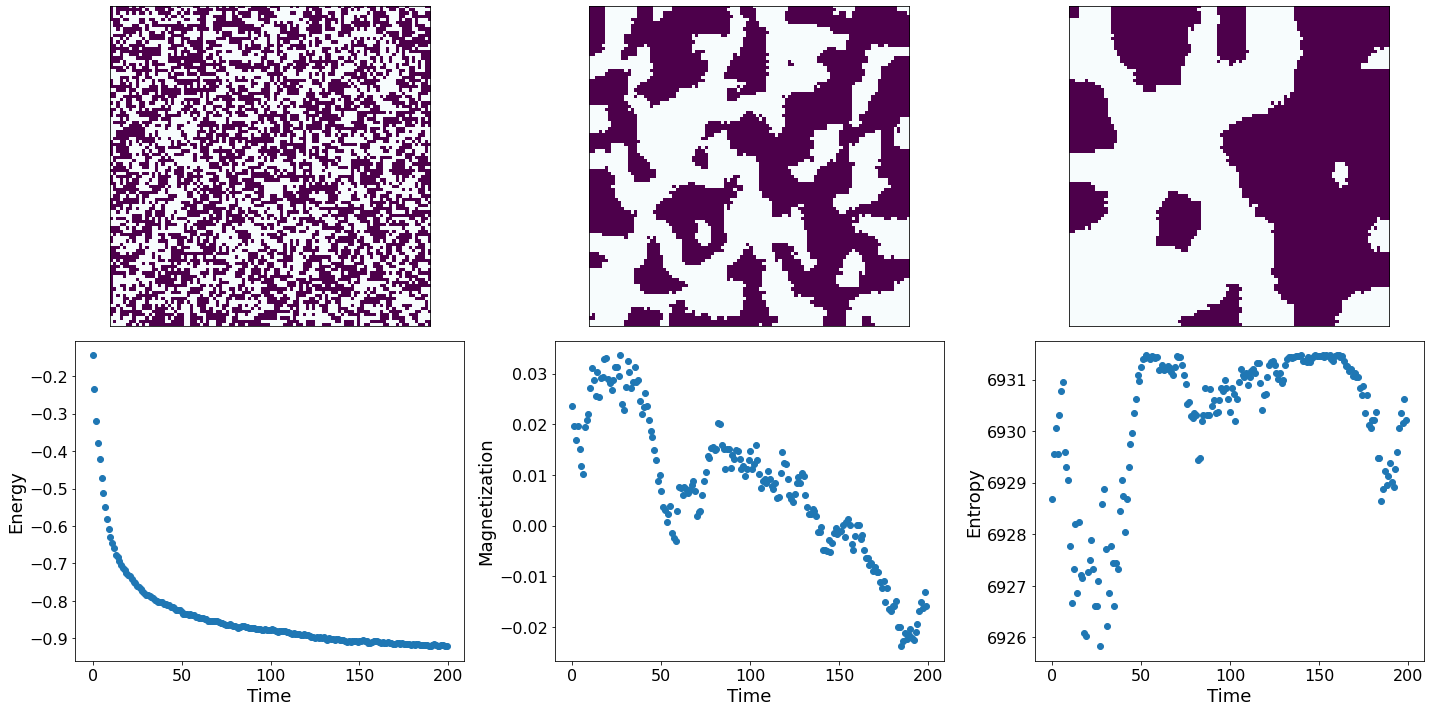

In [7]:
plt.figure(figsize=(20, 10))
e, m, s = [], [], []
N = 200

# Randomize the state (loose memory of previous steps)
spins = ising.spinLattice(100)
spins.randomize()

for i in range(N):
    
    # Make the spin lattice evolve
    spins.thermalEvolution(0.1)
    
    if i == 0:
        plt.subplot(2, 3, 1)
        spins.plot()
    
    if i == int(N/5):
        plt.subplot(2, 3, 2)
        spins.plot() 
    
    if i == N-1:
        plt.subplot(2, 3, 3)
        spins.plot()
    
    # Store all results
    e.append(spins.energy())
    m.append(spins.magnetization())
    s.append(spins.entropy())

plt.subplot(2, 3, 4)
plt.plot(e, 'o')
plt.xlabel('Time')
plt.ylabel('Energy')

plt.subplot(2, 3, 5)
plt.plot(m, 'o')
plt.xlabel('Time')
plt.ylabel('Magnetization')

plt.subplot(2, 3, 6)
plt.plot(s, 'o')
plt.xlabel('Time')
plt.ylabel('Entropy')

plt.tight_layout();

In [8]:
t, e, m, s = spins.simulatePhaseTransition(nT=100)

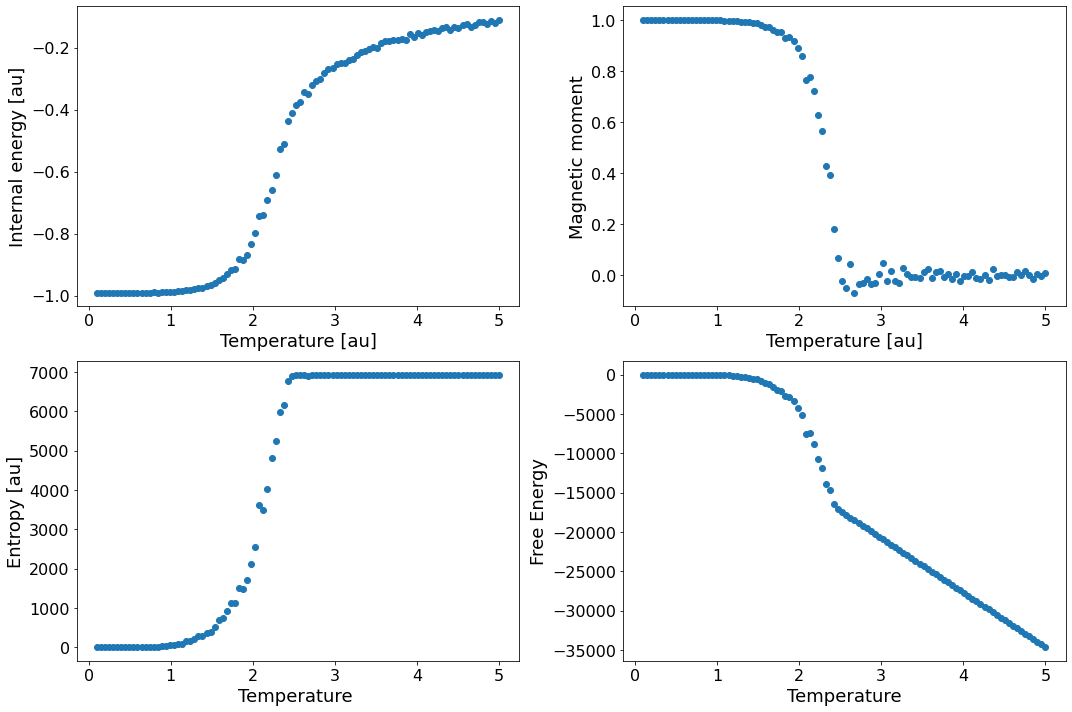

In [9]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(t, e, 'o')
plt.xlabel('Temperature [au]')
plt.ylabel('Internal energy [au]')

plt.subplot(2, 2, 2)
plt.plot(t, np.array(m), 'o')
plt.xlabel('Temperature [au]')
plt.ylabel('Magnetic moment');

plt.subplot(2, 2, 3)
plt.plot(t, s, 'o')
plt.xlabel('Temperature ')
plt.ylabel('Entropy [au]')

plt.subplot(2, 2, 4)
plt.plot(t, e - t*s, 'o')
plt.xlabel('Temperature')
plt.ylabel('Free Energy')

plt.tight_layout()

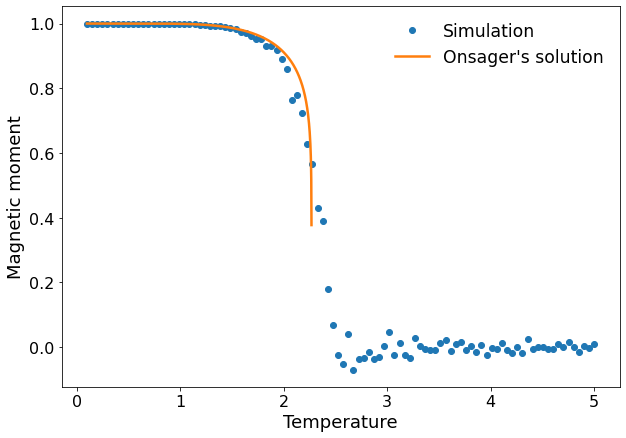

In [10]:
# Adding Onsager analystical solution
def onsagerSolution(T):
    return ( 1 - 1./np.sinh(2/T)**4 ) ** (1./8.)

Tcont = np.linspace(0.1, 2.269, 1000)
plt.plot(t, np.array(m), 'o', label='Simulation')
plt.xlabel('Temperature')
plt.ylabel('Magnetic moment');
plt.plot(Tcont, onsagerSolution(Tcont), label='Onsager\'s solution')
plt.legend();

In [21]:
s = ising.spinLattice(30)
Ts = [0.5, 1., 1.5, 1.75, 2, 2.1, 2.15, 2.175, 2.2, 2.225, 2.25, 2.269, 2.30, 2.35, 2.40, 2.5, 2.6, 2.8, 3, 3.5, 4]
Rs, Gs = [], []

for T in Ts: 
    
    # Start from aligned spins
    s.align()
    
    # Compute 2 points correlation function
    r, g = s.twoPtsCorr(T, nEvolution=20000)

    # Store the results
    Rs.append(r)
    Gs.append(g)

In [22]:
# Save data (averaged over raidii) in a dataframe for later treatment
df = pd.DataFrame()

# Loop over temperatures and correpsonding correlations
for r, g, T in zip(Rs, Gs, Ts):
    
    # Bin data
    gAve, binsEdges, binNumber = stats.binned_statistic(r, g, statistic='mean', bins=25)
    gRms, binsEdges, binNumber = stats.binned_statistic(r, g, statistic=lambda a: a.std(), bins=25)
    gSum, binsEdges, binNumber = stats.binned_statistic(r, g, statistic='sum', bins=25)
    
    # Compute 
    rAve = (binsEdges[1:] + binsEdges[:-1])/2.0
    df['r'] = rAve
    df['MeanT' + str(T)] = gAve
    df['RmsT' + str(T)]  = gRms
    df['SumT' + str(T)]  = gSum

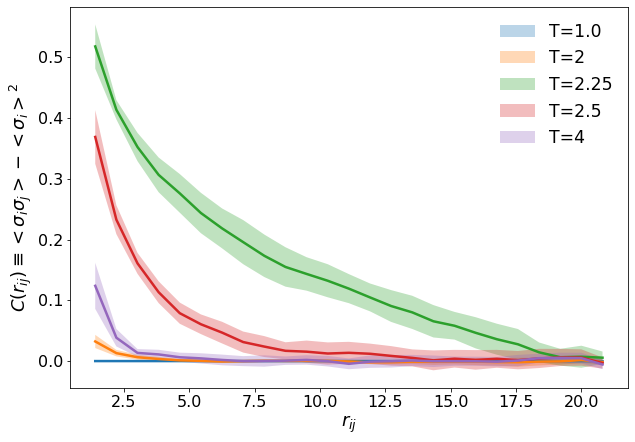

In [23]:
for T in [1., 2, 2.25, 2.50, 4]:
    x, y, dy = df['r'], df['MeanT' + str(T)], df['RmsT' + str(T)]
    plt.plot(x, y)
    plt.fill_between(x, y1=y-dy, y2=y+dy, alpha=0.3, label='T='+str(T))
plt.xlabel('$r_{ij}$')
plt.ylabel('$C(r_{ij}) \\equiv <\\sigma_{i}\\sigma_{j}> - <\\sigma_{i}>^{2}$')
plt.legend();

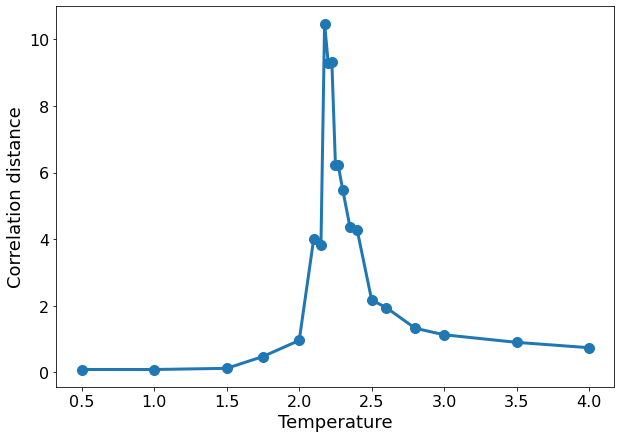

In [24]:
# Compute correlation distance using a exponential decay
def expDecay(x, A, D, X0):
    return A * np.exp( -(x-X0)/D )

# Loop over temperaturews
corrDist = []
for T in Ts:
    x, y = df['r'], df['MeanT' + str(T)]
    p, cov = optimize.curve_fit(expDecay, x, y, p0=[0.25, 0.2, 1], bounds=([0.0, 0.0, 0.5], [1, 20, 2]))
    corrDist.append(p[1])

plt.plot(Ts, corrDist, markersize=10, marker='o', linewidth=3)
plt.ylabel('Correlation distance')
plt.xlabel('Temperature');